# Market Research Analysis for a subset of Crypto-Currencies

The task is to perform some open-ended research and exploratory analysis on the blockchain and market data provided for a selection of  cryptocurrencie. 

# Input DATA

The input  data cointains a CSV file located on Amazon Web Service (AWS)-S3 in the amir-practice bucket and publically accessible via http.

There are two csv files in the bucket and the one named "market_data.csv" consists of market data derived from exchange trades during 01-01-2018 through 02-19-2019 and aggregated at the daily level. The second file named "blockchain_data.csv" consists of blockchain data for a subset of the assets which is also aggregated at the daily level. A short description of the data structure and variables description is also provided in a text file called data_dictionary.docx 

Let's start by reading in the data from the AWS S3 bucket:

In [232]:
#importing the libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Importing the data from Amazon AWS-S3 public bucket
url1 = 'https://s3.amazonaws.com/amir-practice/blockchain_data.csv'
url2 = 'https://s3.amazonaws.com/amir-practice/market_data.csv'

df_bchain = pd.read_csv(url1) 
df_market = pd.read_csv(url2) 

df_bchain[:3] # first look at the DateFrame

,asset_id,epoch_ts,volume_sum,volume_high,volume_low,volume_mean_q,volume_mean_a,volume_mean_g,volume_mean_h,volume_std,...,fee_high,fee_low,fee_mean_q,fee_mean_a,fee_mean_g,fee_mean_h,fee_std,block_reward_sum,supply_total,blockchain_size
0,Bitcoin_BTC_BTC,2019-02-19 00:00:00+00,1.780234e+06,11837.005536,0.0,74.281965,5.112060,0.054446,1.404571e-03,74.105958,...,0.055191,0.0,0.000445,0.000105,0.000039,0.000016,0.000433,1950.000000,1.754774e+07,193912854133
1,Dash_DASH_DASH,2019-02-19 00:00:00+00,3.388989e+05,12879.641105,0.0,324.575946,23.654558,0.173700,3.251968e-03,323.724144,...,0.037780,0.0,0.001894,0.000206,0.000009,0.000007,0.001883,1850.115799,8.310922e+06,8295434127
2,Ethereum_ETH_ETH,2019-02-19 00:00:00+00,2.787835e+06,28467.000000,0.0,137.359364,5.180472,0.223269,8.359763e-15,137.261767,...,0.160157,0.0,0.012248,0.004436,0.001707,0.001073,0.011416,13536.031250,3.327931e+07,73831306948


# Cleaning and reshaping the input data 

As shown in the above table, the input data contains multiple variables (i.e. volume, transaction fees, and etc.) for the individual assets and the data for all assets are stacked together. This data needs to be cleaned and restructured before being used in further analysis. Here I automate the cleaning process by defining a function that would read in the dataframe (df), extract any desired feature (variable i.e. price, volume), sort the timeseries in an ascending order, switch the df index to Date, and seperate all these inforamtion for individual assets. 

In [233]:
def sort_df(df, colmn):
    df1 = df.groupby(['base_asset_id']).get_group('Bitcoin_BTC_BTC')[::-1].loc[:,['epoch_ts']]

    asset_list = ['Bitcoin_BTC_BTC', 'Ethereum_ETH_ETH', 'Litecoin_LTC_LTC','Dash_DASH_DASH', 'Zcash_ZEC_ZEC', 
                  'EOS_EOS_EOS', 'NEO_NEO_NEO', 'Ripple_XRP_XRP', 'Stellar_XLM_XLM','TRON_TRX_TRX']

    for asset in asset_list:
        df1[asset.split('_')[2]] = np.array(df[df['base_asset_id'].str.lower() == asset.lower()][::-1].loc[:,[colmn]])

    #setting date as index
    df1['Date'] = pd.to_datetime(df1.epoch_ts,format='%Y-%m-%d')
    df1.index = df1['Date']
    df1 = df1.drop(['epoch_ts','Date'], axis=1)
    
    return df1

df_price = sort_df(df_market, 'price_close')
df_volume = sort_df(df_market, 'volume_total')

# Converting volume unit to Million USD
df_volume = df_volume*df_price/(1E6)  

In [243]:
def sort2_df(df, colmn):
    df1 = df.groupby(['asset_id']).get_group('Bitcoin_BTC_BTC')[::-1].loc[:,['epoch_ts']]

    asset_list = ['Bitcoin_BTC_BTC', 'Ethereum_ETH_ETH', 'Litecoin_LTC_LTC','Dash_DASH_DASH', 'Zcash_ZEC_ZEC']

    for asset in asset_list:
        df1[asset.split('_')[2]] = np.array(df[df['asset_id'].str.lower() == asset.lower()][::-1].loc[:,[colmn]])

    #setting date as index
    df1['Date'] = pd.to_datetime(df1.epoch_ts,format='%Y-%m-%d')
    df1.index = df1['Date']
    df1 = df1.drop(['epoch_ts','Date'], axis=1)
    
    return df1

df_mined = sort2_df(df_bchain, 'block_reward_sum')
df_mrkt_cap = sort2_df(df_bchain, 'supply_total')
df_txn_fee = sort2_df(df_bchain, 'fee_sum')
df_txn_count = sort2_df(df_bchain, 'fee_sum')
df_txn_volume = sort2_df(df_bchain, 'volume_sum')

# Supply analysis

The balance between demand and supply is a primary driver of market price for many assets. For most cryptocurrencies, the supply rates are transparent and relatively easy to calculate. For bitcoin for example, the supply is the sum of the coins already in circulation and an steady inflation rate (newly mined coins which is equal to the block time multiplied by block reward). Using the available data, I calculated the daily inflation rates for the selected five assets by dividing the new coins mined everyday by the total number of circulating coins (time 100 to convert the unit to %). The results shown below indicate that the inflation rates of bitcoin and litcoin have been fixed in 2018 at about 0.012 % and 0.024%, repectively. For ethereum, dash, and zcash, the inflation rate has been continuously decreasing with zcash and ethereum showing the highest decline (from 0.25% to 0.12% for ZEC and from 0.083% to 0.047% for ETH). 

,BTC,ETH,LTC,DASH,ZEC
Date,,,,,
2018-01-01,0.011623,0.083923,0.025103,0.026185,0.241987
2018-01-02,0.012739,0.083834,0.025417,0.026226,0.237207
2018-01-03,0.011695,0.084165,0.026372,0.025981,0.244180
2018-01-04,0.012513,0.086108,0.028653,0.026356,0.239827


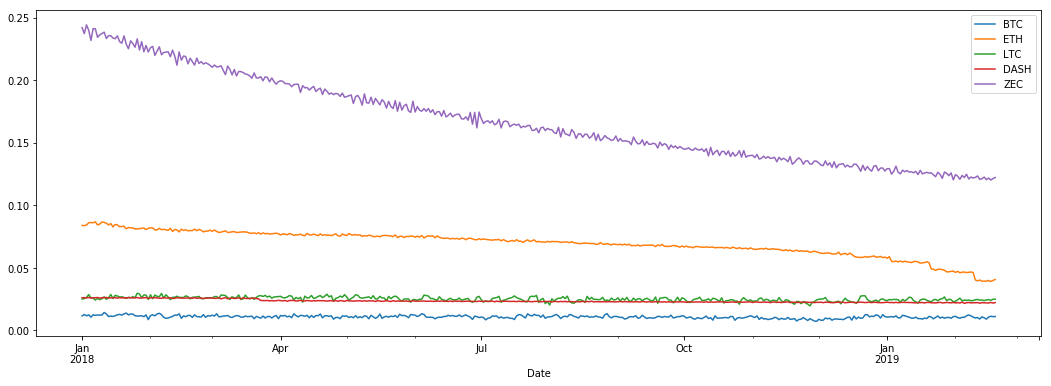

In [280]:
# Calculating daily supply (inflation) rates
df_supply = df_mined/df_mrkt_cap*100
df_supply.plot(figsize=(18,6))
df_supply[:4]

In [256]:
annual_inflation = df_mined['2018-01-01':'2018-12-31'].sum()/df_mrkt_cap['2018-12-31':'2018-12-31']*100
annual_inflation

,BTC,ETH,LTC,DASH,ZEC
Date,,,,,
2018-12-31,3.902596,23.20479,8.813429,8.285375,46.926678


The annual inflation rate (%) of the five crypto assets in 2018 is shown above with zcash and ethereum showing the highest (47% and 23%) and bitcoin indicating the lowest (3.9%) annaul inflation rates. 

# Price-volume relationship

Despite a relatively steady supply rate at the daily to weakly time scales, the price indicates relatively high fluctuations. Much of price variability at these time scales is linked to the changes in the demand. Unlike the supply, the demand for these assets is affected by many factors including the current price, market sentiment, future outlook/speculations, or some external factors i.e. regulations, the Fed monetary policies and interest rates, and potential political and economical instabilities. These factors are hard to measure yet volume can be used as a good metric to measure the demand and the market's response to all these factors. To look at the relation between price and volume, I plotted the timeseires of daily price and volume for bitcoin below. The results indicate a visual relationship where higher price in early 2018 are associated with higher volume.  

<BarContainer object of 415 artists>

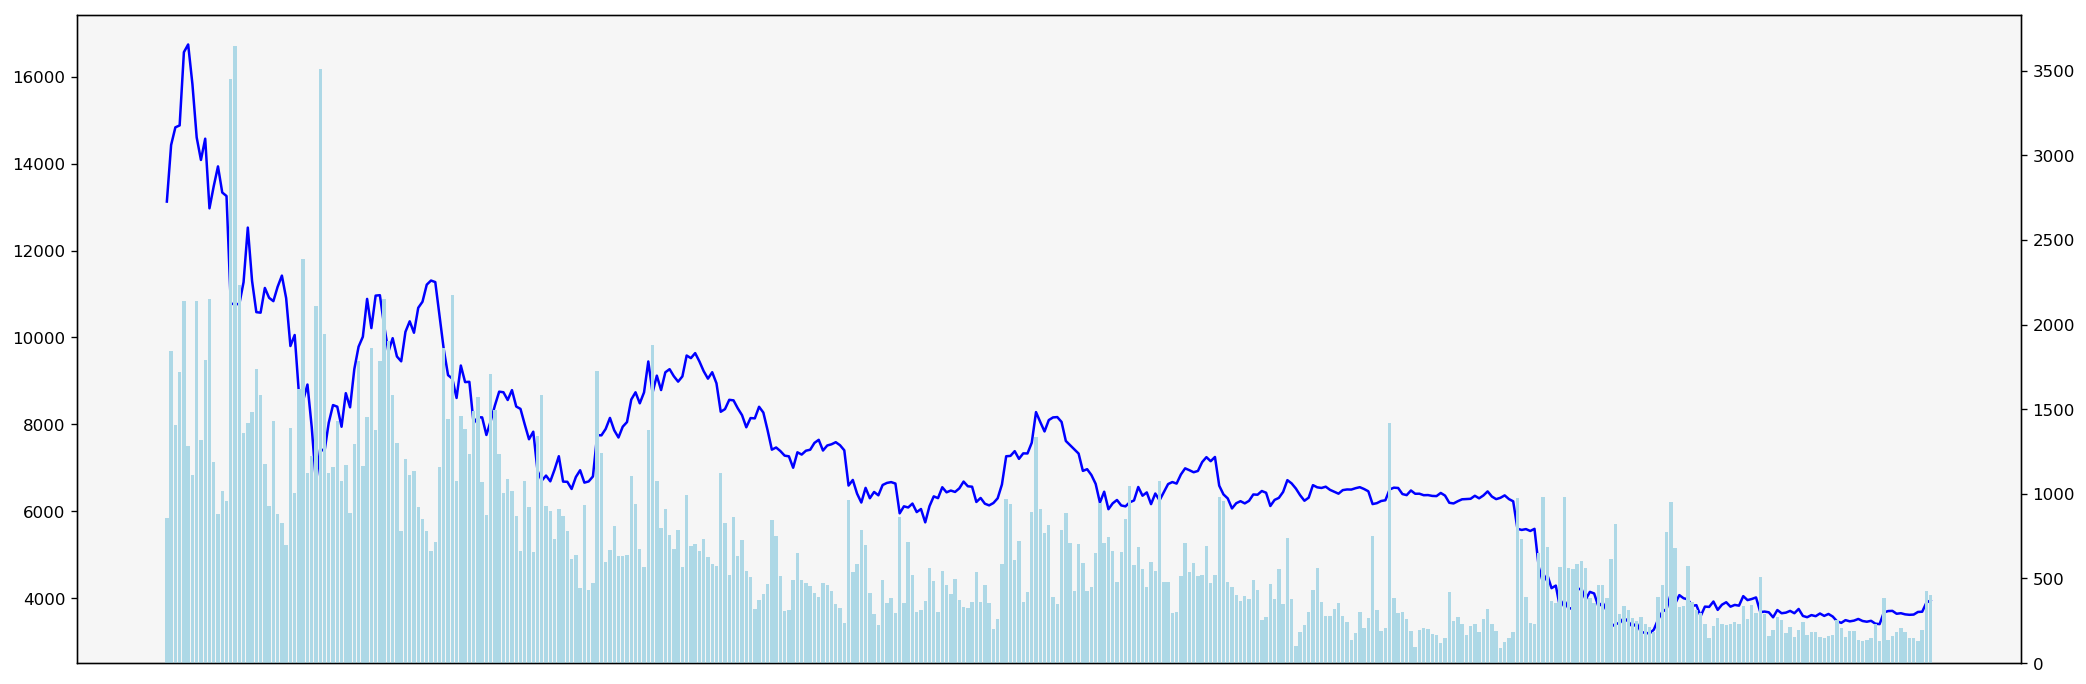

In [203]:
#plot
fig = plt.figure(facecolor='white', figsize=(18, 6), dpi=120)
ax1 = fig.add_axes([0.05, 0.05, 0.9, 0.9], facecolor='#f6f6f6')  
ax2 = plt.twinx()
ax1.tick_params(axis='x', which='both', bottom=False, top=False,  labelbottom=False) 
ax2.tick_params(axis='x', which='both', bottom=False, top=False,  labelbottom=False) 
ax1.plot(df_price.index, df_price['BTC'], color='b') 
ax2.bar(df_price.index, df_volume['BTC'],  color='lightblue')

The strength of price-volume relationship can be quantified using pearson correlation. The correlations were calculated for all of the selected cryptocurrentcies and shown in the bar plot below. The results indicate strong positive correlations for all assets with the smallest corrlation for ZCASH at about 0.5 and the highest for DASH at about 0.8. 

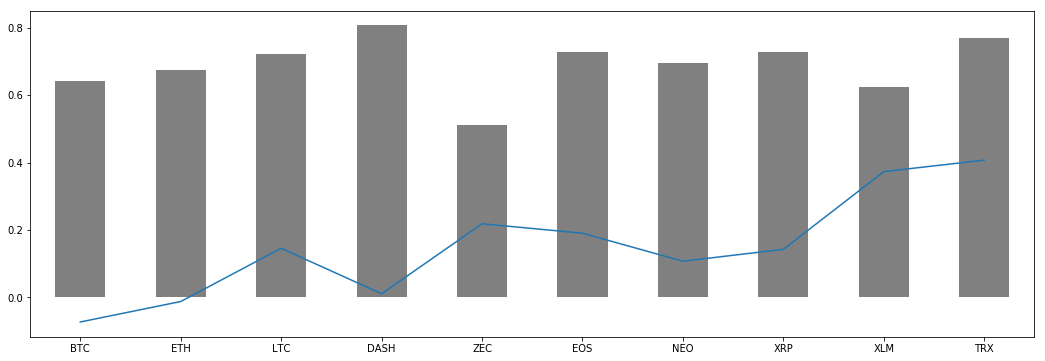

In [231]:
vol_price_corr = df_price.corrwith(df_volume, axis = 0)
vol_price_corr.plot(kind='bar', figsize=(18, 6) ,color='gray')

vol_price_pct_corr = df_price.pct_change().corrwith(df_volume, axis = 0)
ax = plt.gca()
vol_price_pct_corr.plot(ax=ax)

When the correlation are calculated between the daily price change (in %) and daily volume, the results (the blue line in the above figure) indicate nearly zero values for Bitcoin, Ethereum, and Dash and a relatively high value (~0.4) for stellar (XLM) and tron (TRX). Here a positive correlation means a jump in the daily close price is associated with higher volumes and vice versa. The strength of the correlation also represents the degree to which the day to day changes in price are sensitive to daily volume (or vice versa) which may potentially provide some useful hints about liquidity of the asset's market.   

# Correlation between different cryptocurrnecies

Identifying correlated and uncorrelated assets is of a great importance especially for purposes like portfolio diversification and capital management. In the case of crypto assets, the price of almost all alternative coins/tokens is strongly correlated with bitcoin price. This is supported by the correlation matrix shown below for the daily time-scale during the analysis period (Jan 2018-Feb 2019). The strength of the correlation varies among different assets with tron showing the least strongest correlation with bitcoin and all other coins whereas the daily price change of litecoin and ethereum showing the strongest correlation with daily variation of bitcoin price. While correlation does not mean causal relationship and its possible that the USD price of all assets can go up and down simultanously and in response to an external factor (for example an SEC regulation), changes in bitcoin price can act as a causal factor for changes in price of the rest of the crypto assets partially because much of the exchange volume for alternative coins still belongs to their BTC trading pair. One significant consequence of this relationship is that bitcoin price can be used as an independent variable for predicting the price of alternative coins/tokens.

In [284]:
# Calculate the pearson correlation coefficients among all assets
df_price.pct_change().corr(method='pearson')

#plot correlation heatmap 
import plotly.offline as py
import plotly.graph_objs as grpho
#py.init_notebook_mode(connected=True)

df_corr = df_price.pct_change()
htmap = go.Heatmap( z=df_corr.corr(method='pearson').as_matrix(),x=df_corr.columns, y=df_corr.columns,
                     colorbar=dict(title='Pearson Coefficient'))     
htmap['zmax'] , htmap['zmin'] = 1.0 , -1.0
    
fig = go.Figure(data=[htmap])
py.iplot(fig)

df_corr.corr(method='pearson')

/Applications/Anaconda/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:10: FutureWarning:

Method .as_matrix will be removed in a future version. Use .values instead.



,BTC,ETH,LTC,DASH,ZEC,EOS,NEO,XRP,XLM,TRX
BTC,1.000000,0.775628,0.794157,0.706390,0.681710,0.651561,0.708850,0.616552,0.560852,0.454910
ETH,0.775628,1.000000,0.800732,0.746958,0.717547,0.676459,0.798984,0.707877,0.626451,0.442488
LTC,0.794157,0.800732,1.000000,0.725933,0.681800,0.652776,0.697604,0.660246,0.555695,0.382817
DASH,0.706390,0.746958,0.725933,1.000000,0.739649,0.618799,0.702041,0.646179,0.593072,0.440343
ZEC,0.681710,0.717547,0.681800,0.739649,1.000000,0.572368,0.642218,0.610589,0.586464,0.374107
EOS,0.651561,0.676459,0.652776,0.618799,0.572368,1.000000,0.646130,0.625772,0.582255,0.431454
NEO,0.708850,0.798984,0.697604,0.702041,0.642218,0.646130,1.000000,0.638549,0.637918,0.377968
XRP,0.616552,0.707877,0.660246,0.646179,0.610589,0.625772,0.638549,1.000000,0.717050,0.479230
XLM,0.560852,0.626451,0.555695,0.593072,0.586464,0.582255,0.637918,0.717050,1.000000,0.359971
TRX,0.454910,0.442488,0.382817,0.440343,0.374107,0.431454,0.377968,0.479230,0.359971,1.000000


# On chain transaction analysis

A foundamental feature of the blockchain technology is that network information such as (layer 1) transcations are confirmed and stored at each block. Such information are (usually) available to the bublic and analyzing them can provide potentially useful infomation about a network. Here, I plotted the total daily transaction fees collected in  (10E6 or 10 million) USD for five assets during Jan 2018 to Feb 2019. According to the figure, bitcoin and ethereum generated the highest fees over the period with bitoin fees reaching an stagering amount of about 12 million USD per day in Jan 2018. At this time bitcoin experienced its historical all time high price (and volume) since 2009. Higher fees give more insentives to the miners (who receive the fee) and potentially increases the network security. On the other hand, higher transaction fees are not desirable for users (who pay the fee) and many projects have branded themselves for near zero transaction fees to win over more users. 

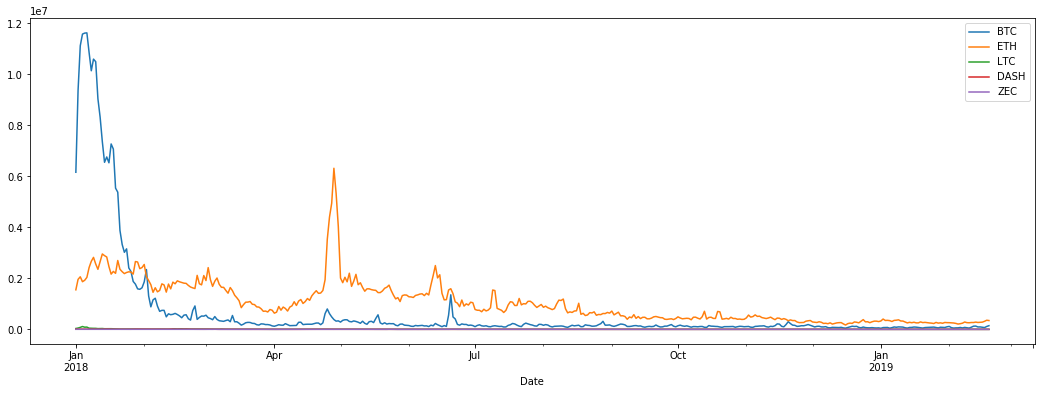

In [268]:
df_txfee_usd = df_txn_fee*df_price[['BTC','ETH','LTC','DASH','ZEC']]
df_txfee_usd.plot(figsize=(18,6))

In order to compare the relative transaction fees of the five assets, one needs to account for the transaction volume. Below, I plotted the transaction volumes in (10E9 or 10 Billion) USD. Among all assets, bitcoin has the highest transaction volume and ethereum and litecoin have the 2nd and 3rd highest volumes. The transaction volumes for all assets are especially high during Jan 2018 which marks the peak of market price during the analysis period and highlights a potentially strong correlations between price and transaction volume. Analyzing transaction volumes and fees can also provide useful information regarding the utility and adoption rates of a network as well as liquidity of its market.   

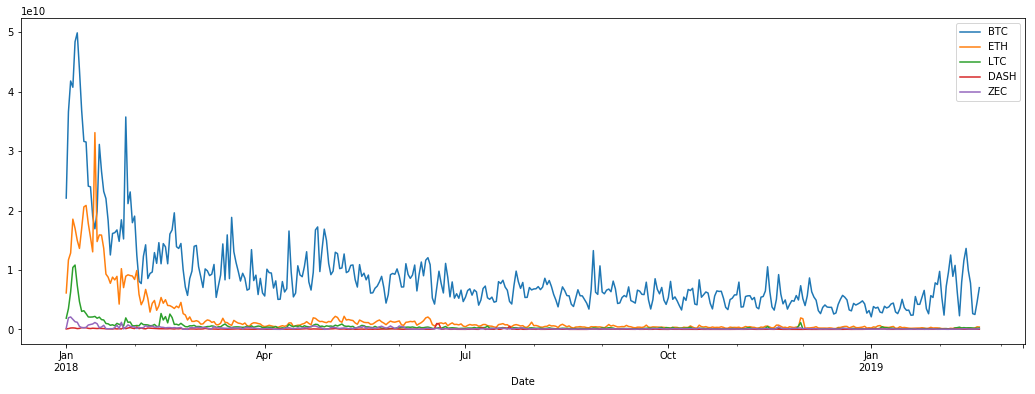

In [269]:
df_txvol_usd = df_txn_volume*df_price[['BTC','ETH','LTC','DASH','ZEC']]
df_txvol_usd.plot(figsize=(18,6))

By dividing the total daily transaction fee by the daily transaction volume, we can compare the relative fees for all five assets. The results (shown below) indicate that the highest fees belong to ethereum at about 0.1% to 0.3%. Bitcoin fees are the 2nd highest by a large margin from those of ethereum with the fees decreasing from 0.05% at its peak in Jan 2018 to about 0.003% in late 2018. Among all assets shown in the figure, zcash has the lowest fees (about 0.00007%) during Feb 2019 which is slightly lower than that of litecoin (0.0004%) and substantially lower than dash fees (0.001%).  

,BTC,ETH,LTC,DASH,ZEC
Date,,,,,
2019-02-16,0.003102,0.209652,0.000266,0.001690,0.000071
2019-02-17,0.002811,0.132018,0.000347,0.001103,0.000057
2019-02-18,0.002477,0.081671,0.000443,0.000958,0.000076
2019-02-19,0.002056,0.085632,0.000357,0.000838,0.000046


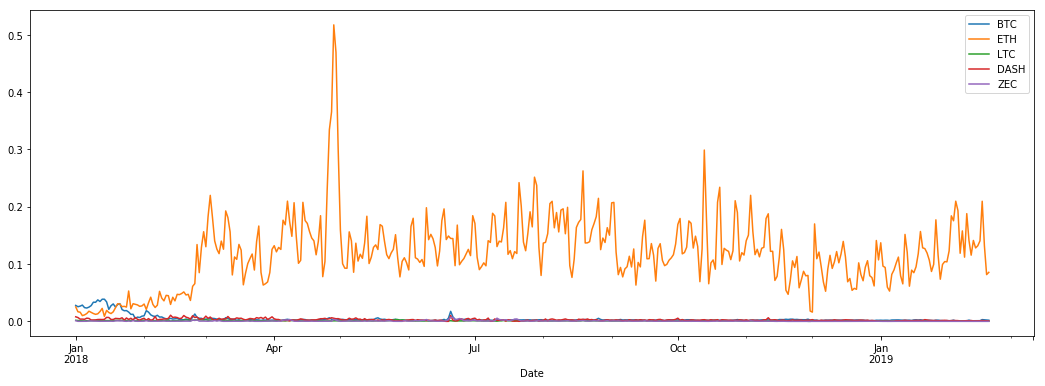

In [281]:
df_txfee_pct = df_txfee_usd/df_txvol_usd*100
df_txfee_pct.plot(figsize=(18,6))
df_txfee_pct[-4:]

In [282]:
# Cross-correlation between exchange volume, onchain volume, price and transaction fees

btc_stat = pd.DataFrame(df_volume['BTC'])
btc_stat.columns = ['exchang_vol']
btc_stat['onchain_vol'] = np.array(df_txvol_usd['BTC'])
btc_stat['price'] = np.array(df_price['BTC'])
btc_stat['txn_fee'] = np.array(df_txfee_pct['BTC'])

btc_stat.corr()

,exchang_vol,onchain_vol,price,txn_fee
exchang_vol,1.000000,0.642405,0.642338,0.532996
onchain_vol,0.642405,1.000000,0.779074,0.704479
price,0.642338,0.779074,1.000000,0.680874
txn_fee,0.532996,0.704479,0.680874,1.000000


# Conclusion

The invention of bitcoin marked the birth of a new asset class, the blockchain assets, with a lifelong of about 10 years and a continuously evolving technology and infrustructures. During this period, the market capitalization has grown steadily yet the market has undergone extreme volatility. At this early stage, major currencies are experiencing various degrees of mass adoption and becoming a potentially attractive asset to some retail investors. However, understading the foundamentals of the technology as well as the market dynamics are very impotant for both users and investors given the disruptive nature of the technology and its advantages/disadvantages (security, privacy, decentralization, fungibility) as compared to other means of store of value (i.e. gold) and medium of exchange (i.e. fiat money).

Here we analyzed various blockchain and market statistcis for a selected number of major crypto currencies/assets. For all assets included in our analysis, there is a strong correlation between price and various market/blockchain metrics. The price of all assets peaked at Jan 2018 when the market witnessed the highest volume and the network recorded maximum transaction volume and fees. 

While the analysis conducted here can provide potentially usefull information, it should be noted that they are perliminary analysis and the results are only valid over the study period and the conclusions may not hold for other periods. Expanding these analysis over longer time periods and different time scales and including additional metrics to account for trends, variability and volatility, momentum, and market sentiment/emotions may significantly improve the quality of cryptocurrencies market research analysis. 
